In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt

### 导入cora数据集

In [193]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0]  # Get the first graph object.

print()
print(graph)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Number of training nodes: {graph.train_mask.sum()}')
print(f'Training node label rate: {int(graph.train_mask.sum()) / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### 定义一个GraphSAGE_model

In [194]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.sage1 = torch_geometric.nn.SAGEConv(input_dim, hidden_dim1, aggr='mean')
        self.sage2 = torch_geometric.nn.SAGEConv(hidden_dim1, hidden_dim2, aggr='mean')
        self.layer = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x, edge_index):
        # print(x.shape)
        # print(edge_index.shape)
        x = self.sage1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.layer(x)
        return x

### 模型训练

In [195]:
model = GraphSAGE(input_dim=dataset.num_features,
            hidden_dim1=128,
            hidden_dim2=16,
            output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

In [196]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9516
Epoch: 002, Loss: 1.9481
Epoch: 003, Loss: 1.9325
Epoch: 004, Loss: 1.9199
Epoch: 005, Loss: 1.8886
Epoch: 006, Loss: 1.8456
Epoch: 007, Loss: 1.8109
Epoch: 008, Loss: 1.7277
Epoch: 009, Loss: 1.6278
Epoch: 010, Loss: 1.5441
Epoch: 011, Loss: 1.4089
Epoch: 012, Loss: 1.2828
Epoch: 013, Loss: 1.1771
Epoch: 014, Loss: 1.1298
Epoch: 015, Loss: 0.9545
Epoch: 016, Loss: 0.9055
Epoch: 017, Loss: 0.8104
Epoch: 018, Loss: 0.7432
Epoch: 019, Loss: 0.6940
Epoch: 020, Loss: 0.5969
Epoch: 021, Loss: 0.6218
Epoch: 022, Loss: 0.5800
Epoch: 023, Loss: 0.6167
Epoch: 024, Loss: 0.6329
Epoch: 025, Loss: 0.6076
Epoch: 026, Loss: 0.4565
Epoch: 027, Loss: 0.4899
Epoch: 028, Loss: 0.5095
Epoch: 029, Loss: 0.4932
Epoch: 030, Loss: 0.4476
Epoch: 031, Loss: 0.4542
Epoch: 032, Loss: 0.4890
Epoch: 033, Loss: 0.5332
Epoch: 034, Loss: 0.4803
Epoch: 035, Loss: 0.3440
Epoch: 036, Loss: 0.4303
Epoch: 037, Loss: 0.3994
Epoch: 038, Loss: 0.5425
Epoch: 039, Loss: 0.4966
Epoch: 040, Loss: 0.4149


### 测试集准确率

In [197]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}\n')

model.eval()
with torch.no_grad():  # 显著减少显存占用
    output = model(graph.x, graph.edge_index)


Test Accuracy: 0.7540



### 结果可视化

In [198]:
output.shape

torch.Size([2708, 7])

In [199]:
graph.y

tensor([3, 4, 4,  ..., 3, 3, 3])

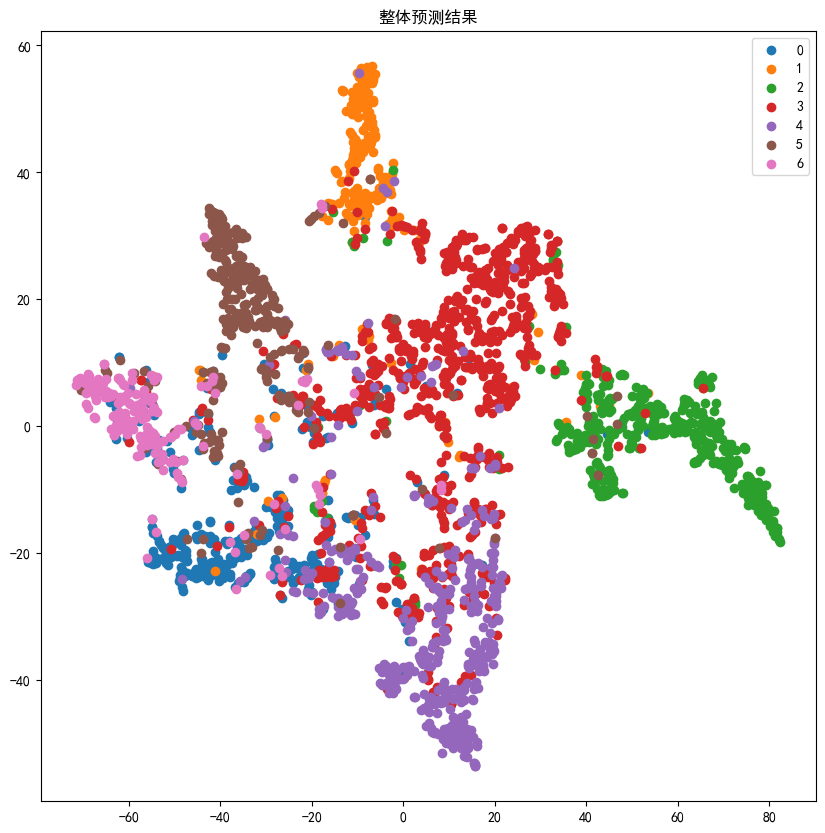

In [200]:
# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))
for i in range(7):
    indices = graph.y == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.title("整体预测结果")
plt.legend()
plt.show()